In [35]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['deleted', 'removed'])

In [65]:
df = pd.read_csv('test6.csv')
print(len(df))

165490


In [66]:
data = df.body.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['if', 'wanted', 'to', 'get', 'emotionally', 'battered', 'and', 'fucked', 'repeatedly', 'visit', 'my', 'in', 'laws']]


In [67]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['if', 'wanted', 'to', 'get', 'emotionally', 'battered', 'and', 'fucked', 'repeatedly', 'visit', 'my', 'in', 'laws']


In [68]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [70]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['want', 'get', 'emotionally', 'batter', 'fuck', 'repeatedly', 'visit', 'law']]


In [71]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [72]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

KeyboardInterrupt: 

In [45]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -16.491716827601515

Coherence Score:  0.3761501373586641


In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'test.html')

In [73]:
mallet_path = '/Users/stuartbman/GitHub/reddit_scraper/mallet/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

KeyboardInterrupt: 

In [48]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('time', 0.13694343124770683),
   ('start', 0.05505795005719465),
   ('end', 0.04020892236634796),
   ('long', 0.03846790264678163),
   ('month', 0.03731681522888654),
   ('leave', 0.034000244606076306),
   ('back', 0.031007417319549063),
   ('year', 0.028518190778350924),
   ('change', 0.0272160231368571),
   ('give', 0.02484190533744847)]),
 (19,
  [('patient', 0.1352062331820555),
   ('referral', 0.016212163808452817),
   ('review', 0.01619208268069668),
   ('refer', 0.012791678380657858),
   ('case', 0.011740766028086803),
   ('clinical', 0.011091476230638445),
   ('note', 0.010703241094019841),
   ('report', 0.010187825481612381),
   ('management', 0.00975273438022946),
   ('pain', 0.009585391648928337)]),
 (16,
  [('question', 0.038432082434031886),
   ('answer', 0.02817424400659101),
   ('read', 0.025954033125236912),
   ('comment', 0.024739492677945646),
   ('email', 0.022093805843718815),
   ('post', 0.0203609583265644),
   ('find', 0.01950227049440306),
   ('write', 0

In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.

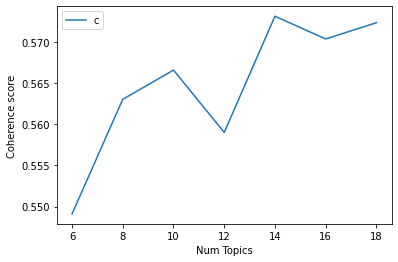

In [75]:
# Show graph
limit=20
start=6
step=2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [76]:
print(len(model_list))
optimal_model = model_list[4]
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
pyLDAvis.save_html(vis, 'test.html')
print(len(df))

7
165490


In [77]:
model.print_topics()

[(0,
  '0.039*"question" + 0.033*"post" + 0.021*"read" + 0.020*"answer" + 0.017*"find" + 0.016*"write" + 0.015*"email" + 0.012*"follow" + 0.012*"comment" + 0.012*"reply"'),
 (1,
  '0.074*"consultant" + 0.029*"specialty" + 0.024*"experience" + 0.023*"trainee" + 0.020*"lot" + 0.019*"hospital" + 0.018*"surgical" + 0.018*"speciality" + 0.017*"surgery" + 0.015*"general"'),
 (2,
  '0.084*"pay" + 0.026*"money" + 0.017*"private" + 0.017*"salary" + 0.016*"high" + 0.015*"nhs" + 0.014*"country" + 0.014*"year" + 0.013*"earn" + 0.013*"rate"'),
 (3,
  '0.053*"medical" + 0.035*"point" + 0.034*"school" + 0.028*"student" + 0.027*"clinical" + 0.024*"exam" + 0.021*"part" + 0.021*"med" + 0.016*"interview" + 0.015*"teach"'),
 (4,
  '0.039*"hospital" + 0.021*"live" + 0.020*"place" + 0.018*"nice" + 0.018*"good" + 0.016*"great" + 0.014*"big" + 0.014*"pretty" + 0.010*"lol" + 0.010*"guy"'),
 (5,
  '0.077*"good" + 0.058*"thing" + 0.041*"gp" + 0.034*"time" + 0.033*"give" + 0.029*"make" + 0.024*"practice" + 0.023*

In [78]:
topic_titles={
    0: 'Clinical advice',
    1: 'Doctors role',
    2: 'Training',
    3: 'Lifestyle/work-life balance',
    4: 'Misc',
    5: 'MDT',
    6: 'Medical School',
    7: 'Pay & remuneration',
    8: 'Concerns & worries',
    9: 'Working hours',
    10: 'Union/ Industrial action',
    11: 'Hospital/deanery reviews',
    12: 'Communication via electronic medium',
    13: 'Misc'
}

In [79]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/stuartbman/GitHub/reddit_scraper/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/stuartbman/GitHub/reddit_scraper/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/stuartbman/GitHub/reddit_scraper/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/stuartbman/GitHub/reddit_scraper/venv/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.0876,"hospital, live, place, nice, good, great, big,...","""If I wanted to get emotionally battered and f..."
1,1,3.0,0.2062,"medical, point, school, student, clinical, exa...",I think there’s a few things:\n\n- I had such ...
2,2,8.0,0.1258,"feel, make, thing, bad, shit, back, put, start...",I rarely hear it from doctors. Most have been...
3,3,11.0,0.2058,"covid, give, risk, high, case, low, test, pain...",and what about CO2 and monitoring? \n\na ward ...
4,4,8.0,0.1114,"feel, make, thing, bad, shit, back, put, start...","Conscious or not, it’s not the truth. You’ll m..."
5,5,11.0,0.2332,"covid, give, risk, high, case, low, test, pain...",> give some PEEP via the waters circuit\n\nbe ...
6,6,4.0,0.0967,"hospital, live, place, nice, good, great, big,...","No traffic this week, it's amazing!"
7,7,11.0,0.3228,"covid, give, risk, high, case, low, test, pain...",> I’m a fan of roc only.\n\nSame.\n\nIf they'r...
8,8,9.0,0.1296,"patient, ward, nurse, call, team, senior, bloo...",Oh. I think you'll find that it's the fact laz...
9,9,0.0,0.0847,"question, post, read, answer, find, write, ema...","yup, way more iphones in my experience, especi..."


In [80]:
df_dominant_topic['sentiment']=df['sentiment']
df_dominant_topic['created_utc']=df['created_utc']

In [81]:
remove_zero=True #Change this if you don't want to remove sentiments approximately zero
if remove_zero:
    print(len(df_dominant_topic))
    df=df_dominant_topic
    df_unremove = df_dominant_topic
    df = df.drop(df[(df.sentiment < 0.05) & (df.sentiment > -0.05)].index)
    df_dominant_topic=df
    print(len(df_dominant_topic))

165490
123011


In [82]:
topic_sentiment=df_dominant_topic.groupby('Dominant_Topic')['sentiment'].mean().to_frame()
topic_sentiment['median']=df_dominant_topic.groupby('Dominant_Topic')['sentiment'].median()

topic_sentiment['theme']=topic_titles.values()

topic_sentiment

,sentiment,median,theme
Dominant_Topic,,,
0.0,0.331471,0.41730,Clinical advice
1.0,0.357856,0.49390,Doctors role
2.0,0.267423,0.40190,Training
3.0,0.387010,0.50230,Lifestyle/work-life balance
4.0,0.382166,0.49390,Misc
5.0,0.433123,0.57190,MDT
6.0,0.231263,0.37160,Medical School
7.0,0.424358,0.62490,Pay & remuneration
8.0,0.044631,0.11540,Concerns & worries


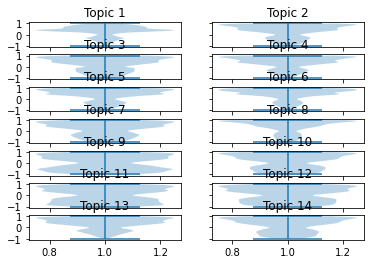

In [83]:
fig, axs = plt.subplots(nrows=7, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
for n, topic_n in enumerate(set(df_dominant_topic['Dominant_Topic'])):
    grouped=df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic_n]
    axs[n].violinplot(grouped['sentiment'])
    axs[n].title.set_text('Topic {}'.format(n+1))
plt.gcf().set_facecolor('white')
plt.rcParams['figure.figsize'] = [10, 20]
plt.subplots_adjust(hspace=0.3)

Index(['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords',
       'Text', 'sentiment', 'created_utc'],
      dtype='object')


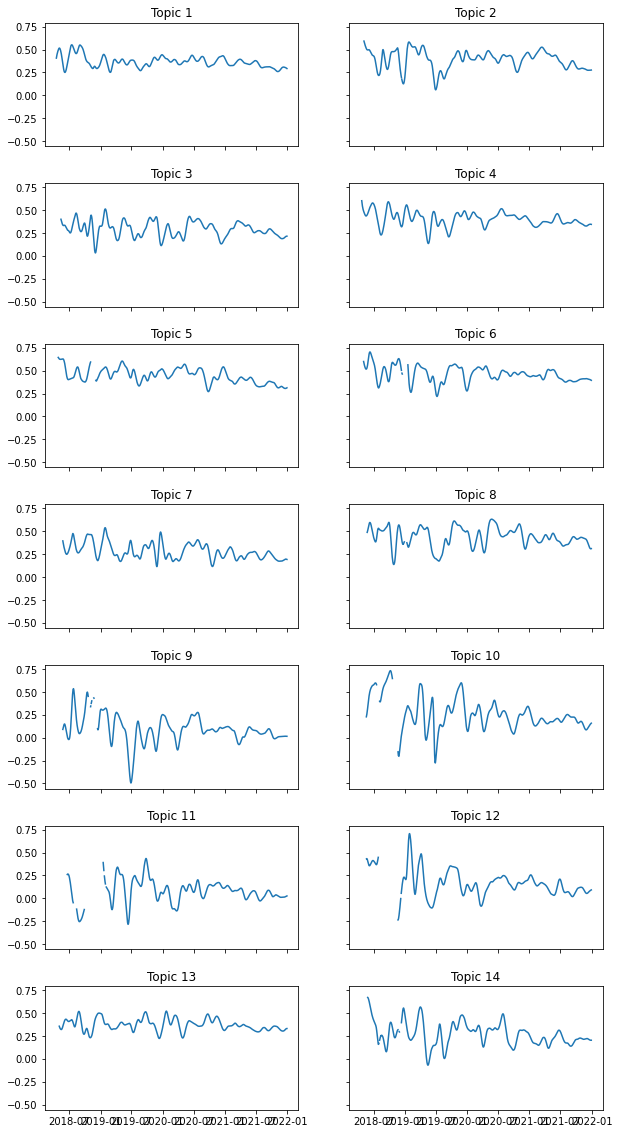

In [84]:
duration = 60
# For topic in topics:
    #plot rolling mean of comments within each topic over time
fig, axs = plt.subplots(nrows=7, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
print(df_dominant_topic.columns)
for n, topic_n in enumerate(set(df_dominant_topic['Dominant_Topic'])):
    topic_comments = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic_n]
    topic_comments['created_utc'] = pd.to_datetime(topic_comments['created_utc'], unit='s')
    topic_comments = topic_comments.set_index('created_utc')
    topic_comments = topic_comments.resample("1d").mean().rolling(window=duration, min_periods=10, win_type='hanning').mean()
    topic_comments['sentiment_sem'] = topic_comments.resample("1d")['sentiment'].mean().rolling(window=duration, min_periods=10).sem()
    axs[n].plot(topic_comments['sentiment'])

    axs[n].title.set_text('Topic {}'.format(n+1))
plt.rcParams['figure.figsize'] = [10, 20]
plt.subplots_adjust(hspace=0.3)
plt.gcf().set_facecolor('white')
plt.show()